In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# try a dataset, save all spectrograms somewhere
filenames = glob.glob("/home/kchow/datasets/clips/*.mp3")
cqt_clips = []

restart = False

number_of_clips = 10

# if numpy loaded 
if not restart and os.path.isfile('cqt_clips_.npy'):
    cqt_clips = np.load('cqt_clips_.npy')
else:
    for f in filenames:
        print(f)
        y, sr = librosa.load(f)
        C = np.abs(librosa.cqt(y, sr=sr))
        C = C[:84,:1939]
        if np.shape(C)[0] != 84 or np.shape(C)[1] != 1939:
            continue
        cqt_clips.append(C)
        if len(cqt_clips) == number_of_clips:
            break

np.save('cqt_clips_.npy', np.array(cqt_clips))



In [9]:
np.shape(cqt_clips)

(10, 84, 1939)

In [3]:
batch_size = 8
epochs = 100
no_cuda = False
seed = 1
beta = 0
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 128
fc_dimensions = 512

In [4]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [5]:
time_steps = 1939
freq_filters = 84
variable = 967
# 484 967
class MusicCQTAE(nn.Module):
    def __init__(self):
        super(MusicCQTAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        
        #self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        #self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        # stride 1 1935
        self.fc1 = nn.Linear(256*variable, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*variable)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return x
        #return self.mu_i(x), self.var_i(x)
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, variable)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [6]:
time_steps = 1939
freq_filters = 84
variable = 967
class MusicCQTVAE(nn.Module):
    def __init__(self):
        super(MusicCQTVAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        
        self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*variable, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*variable)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return self.mu_i(x), self.var_i(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, variable)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [54]:
model = MusicCQTVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    if loss_function_type == 'DIP-VAE1':
        return DIP_1_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'DIP-VAE2':
        return DIP_2_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'Beta':
        return beta_loss_function(recon_x, x, mu, logvar)

def beta_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + (beta*(KLD)) #/recon_x.size(0))
    

def DIP_1_loss_function(recon_x, x, mu, logvar):
    exp_mu = mu.mean(0)
    # should this mu be on the 0th or 1st axis?
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    cov = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    # diag = diagonal matrix returned, diag_part just the diagonal (diagonal)
    diag_part = torch.diagonal(cov) 
    off_diag_part = cov - torch.diag(diag_part)

    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)


def DIP_2_loss_function(recon_x, x, mu, logvar):
    sigma = torch.diag(logvar)
    exp_cov = sigma.mean(0)
    
    exp_mu = mu.mean(0)
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    
    cov_exp = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    cov_z = cov_exp + exp_cov
    
    diag_part = torch.diagonal(cov_z)
    off_diag_part = cov_z - torch.diag(diag_part)
    
    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)
# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
average_losses = []
def train(epoch):
    model.train()
    train_loss = 0
    subset_data = cqt_clips[:8]
    import random
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)# /data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

    
    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [7]:
model = MusicCQTAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    #MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = cqt_clips[9:10]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


1 0.0880804136395
====> Epoch: 1 Average loss: 0.0881
2 0.0640739202499
====> Epoch: 2 Average loss: 0.0641
3 0.456161677837
====> Epoch: 3 Average loss: 0.4562
4 0.108609199524
====> Epoch: 4 Average loss: 0.1086
5 0.0729504600167
====> Epoch: 5 Average loss: 0.0730
6 0.0737423077226
====> Epoch: 6 Average loss: 0.0737
7 0.070978872478
====> Epoch: 7 Average loss: 0.0710
8 0.0744908004999
====> Epoch: 8 Average loss: 0.0745
9 0.0668425932527
====> Epoch: 9 Average loss: 0.0668
10 0.0633480101824
====> Epoch: 10 Average loss: 0.0633
11 0.0597848333418
====> Epoch: 11 Average loss: 0.0598
12 0.0552737861872
====> Epoch: 12 Average loss: 0.0553
13 0.051487788558
====> Epoch: 13 Average loss: 0.0515
14 0.0494295284152
====> Epoch: 14 Average loss: 0.0494
15 0.0466603077948
====> Epoch: 15 Average loss: 0.0467
16 0.0447567924857
====> Epoch: 16 Average loss: 0.0448
17 0.0445002280176
====> Epoch: 17 Average loss: 0.0445
18 0.0444171279669
====> Epoch: 18 Average loss: 0.0444
19 0.044297851

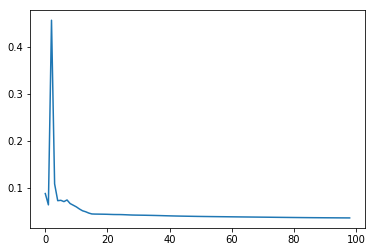

In [8]:
for epoch in range(1, 100):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

In [16]:
sr = 22050

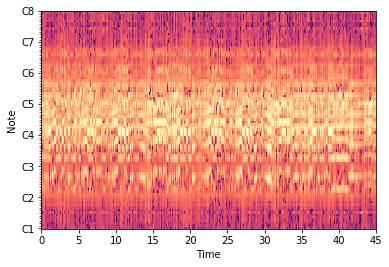

In [43]:
# AE
with torch.no_grad():
    sample = cqt_clips[0]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
    

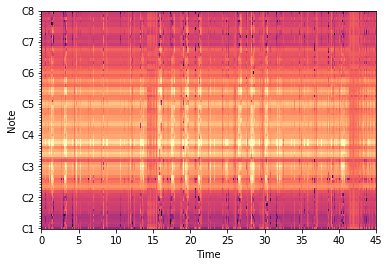

In [56]:
# VAE
with torch.no_grad():
    sample = cqt_clips[0]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    z = model.reparameterize(mu, logvar)
    #sample = torch.randn(1, latent_dimensions).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')

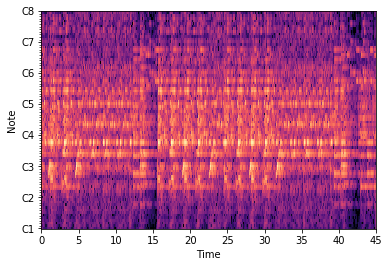

In [51]:
librosa.display.specshow(librosa.amplitude_to_db(cqt_clips[0], ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')